# Reproduction of Fig. 2

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from matplotlib.colors import ListedColormap
from matplotlib.collections import PatchCollection
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec
from matplotlib.ticker import MultipleLocator
from pyscripts.config import path2
from pyscripts.datasets import Metadata
from pyscripts.visualization import ColorUniversalDesign as CUD

metadata = Metadata()

In [2]:
idp_summary = pd.read_pickle(
    path2.data/'iupred2a'/'summary.pkl.bz2'
).swaplevel(0,1,axis=1).swaplevel(1,2,axis=1).sort_index(axis=1)

In [3]:
nts_summary = pd.read_pickle(path2.data/'kmer'/'nts_summary.pkl.bz2')
GC = nts_summary.T.eval('(G+C)/(G+C+A+T)*100')

In [4]:
gtdbrep2refseq = metadata.acc.set_index('gtdbrep')['refseq']
refseq2gtdbrep = metadata.acc.set_index('refseq')['gtdbrep']
acc_ordered = pd.DataFrame([
    (refseq_acc, gtdb_acc)
    for gtdb_acc in metadata.bac120_tree.iter_leaf_names() 
    if (refseq_acc := gtdbrep2refseq.get(gtdb_acc)) is not None
], columns=['refseq', 'gtdbrep'])
gtdb_taxonomy = metadata.taxrank_inuse.loc[acc_ordered['gtdbrep']]

phylum_counts = gtdb_taxonomy['phylum'].value_counts()[gtdb_taxonomy['phylum'].unique()]
top_idx = phylum_counts[phylum_counts >= 40].sort_values(ascending=False).index
phylum_masked = gtdb_taxonomy['phylum'].where(gtdb_taxonomy['phylum'].isin(top_idx), '(others)')
phylum_color = (phylum_counts.rank(method='first', ascending=False).astype(int)-1).apply(CUD.OkabeIto_cmap)

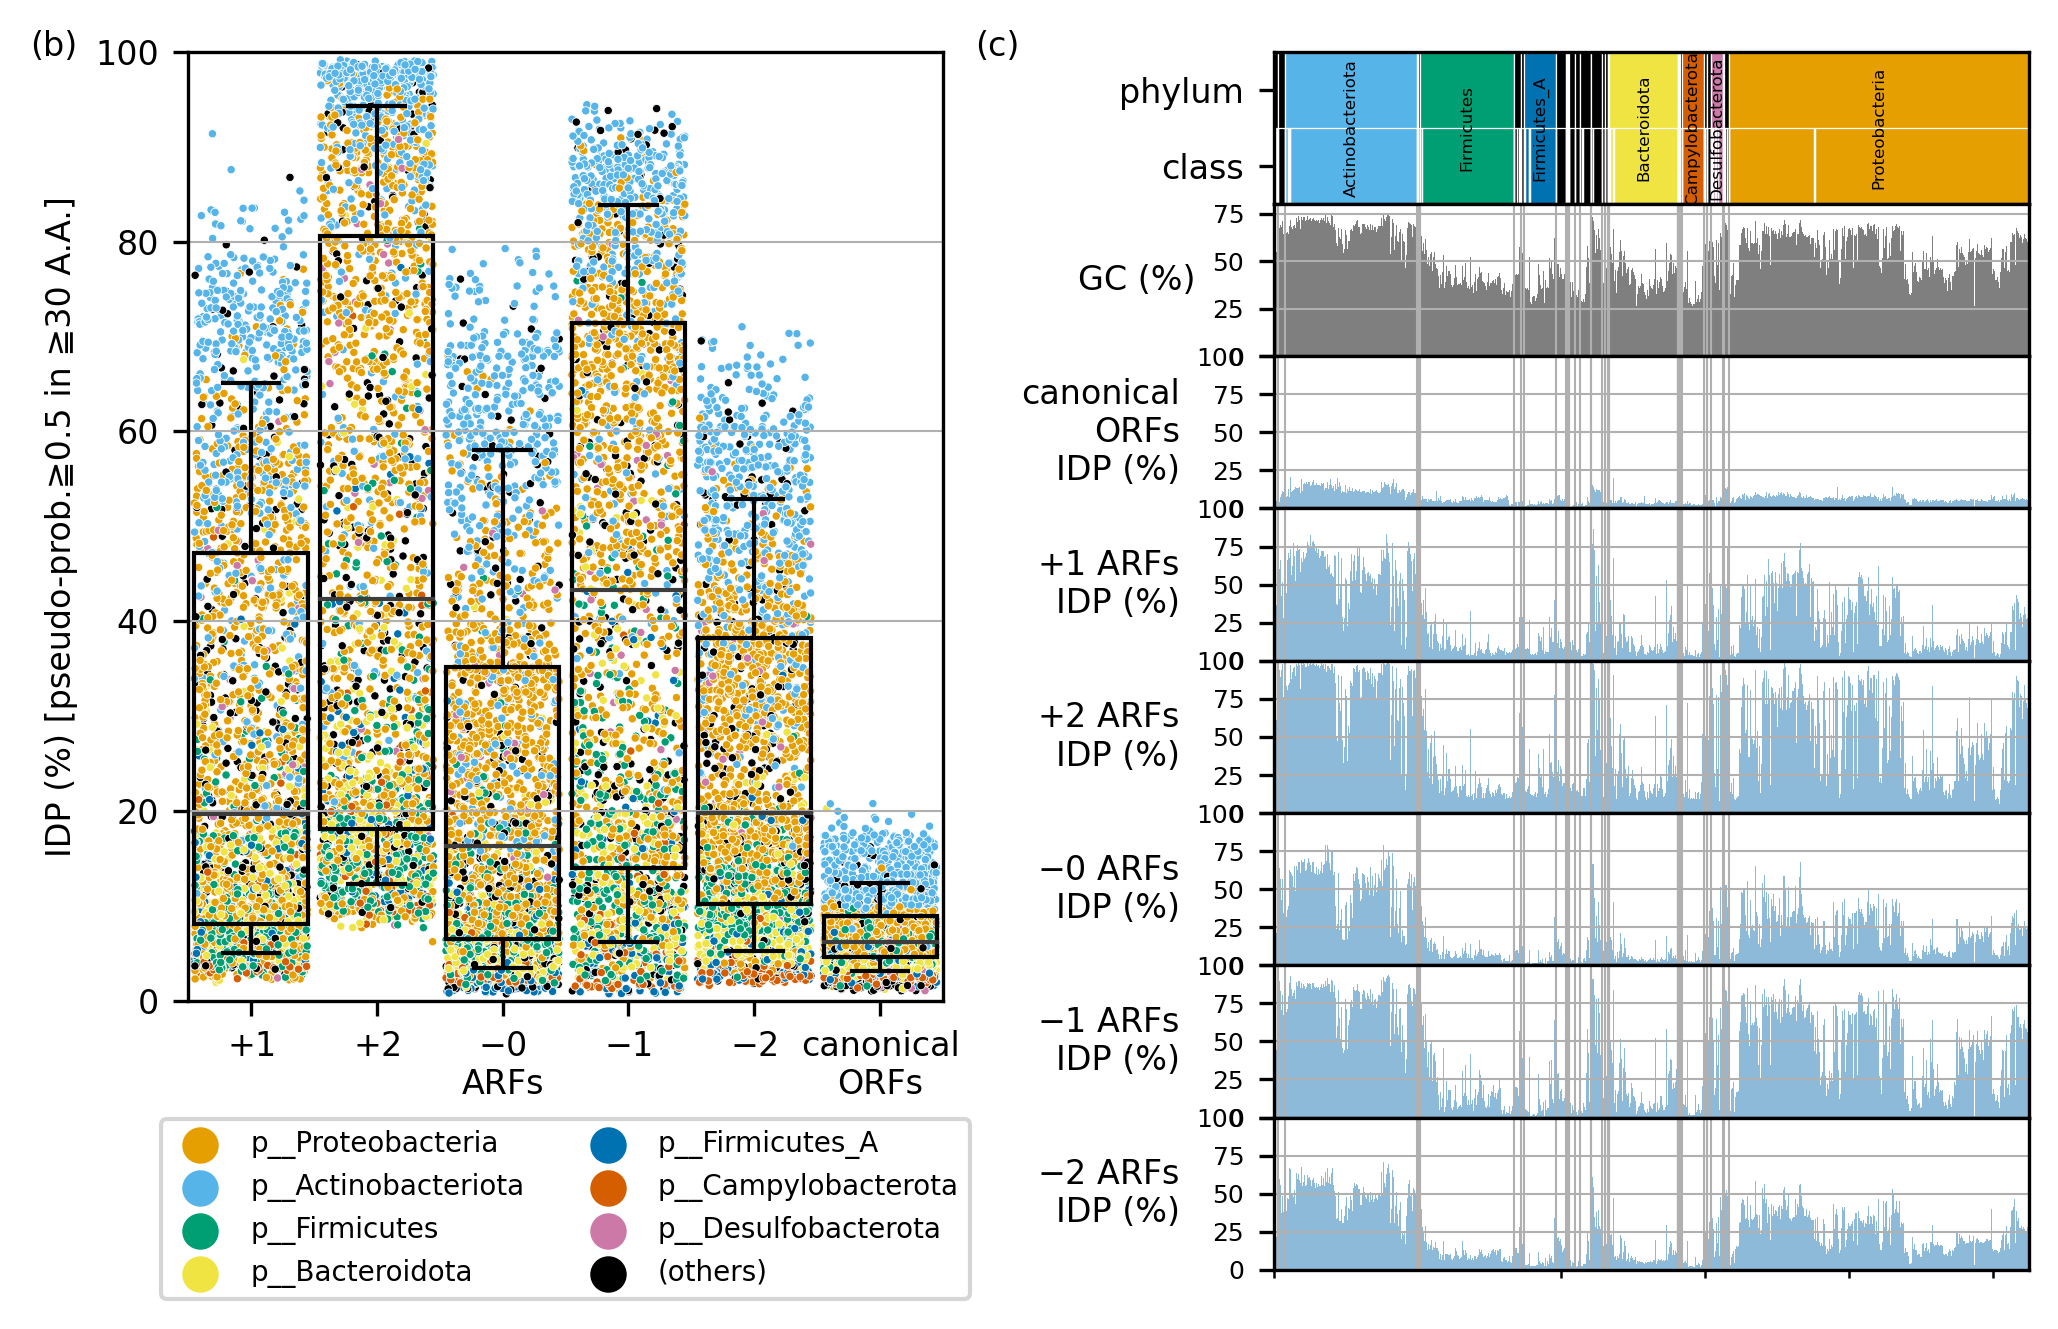

In [14]:
mm = 1 / 25.4

with plt.rc_context({'font.size': 8, 'grid.linewidth': 0.5}):
    fig = plt.figure(figsize=(174*mm, 115*mm), dpi=300)

    # Layout
    gs = GridSpec(1, 2)
    gs_left  = GridSpecFromSubplotSpec(2, 1, subplot_spec=gs[0, 0], height_ratios=[6, 1])
    gs_right = GridSpecFromSubplotSpec(8, 1, subplot_spec=gs[0, 1], hspace=0)
    ax_left = fig.add_subplot(gs_left[0])
    axes_right, ax = [], None
    for gs_left_sub in gs_right:
        axes_right.append(ax:=fig.add_subplot(gs_left_sub, sharex=ax))
        
    # Panel (b)
    ax = ax_left
    fr_mapping = {0: 'undet', 1: 'CDS', 2: '+1',  4: '+2',  8: '-0', 16: '-1', 32: '-2'}
    len_thresh, prob_thresh = 30, 0.5
    idp_ratio = idp_summary[len_thresh,prob_thresh] / idp_summary[len_thresh,0.0].fillna(0) * 100
    pltdata = idp_ratio.rename_axis(index='frame', columns='gcf').rename(index=fr_mapping).stack().rename('IDP').reset_index()
    pltdata = pltdata.assign(phylum=pltdata['gcf'].map(refseq2gtdbrep).map(phylum_masked))
    
    sns.boxplot(
        x='frame', y='IDP', data=pltdata, order=['+1', '+2', '-0', '-1', '-2', 'CDS'], width=0.9,
        #hue='phylum', hue_order=[*top_idx, '(others)'], palette=CUD.OkabeIto_cpal,
        linewidth=1, ax=ax, capprops={'color':'k', 'zorder': 1}, whiskerprops={'color':'k', 'zorder': 1}, boxprops={'facecolor':'none', 'edgecolor':'k', 'zorder': 1}, whis=[10, 90], fliersize=0
    )
    sns.stripplot(
        x='frame', y='IDP', data=pltdata, order=['+1', '+2', '-0', '-1', '-2', 'CDS'],
        hue='phylum', hue_order=[*top_idx, '(others)'], palette=CUD.OkabeIto_cpal,
        jitter=0.45, s=2, ec='w', linewidth=0.2, ax=ax, zorder=0
    )
    
    ax.legend(loc='upper center', ncol=2, bbox_to_anchor=(0.5, -0.11), fontsize='small')
    ax.set_xlabel(None)
    ax.set_ylim(0, 100),
    ax.set_ylabel(f'IDP (%) [pseudo-prob.≧{prob_thresh} in ≧{len_thresh} A.A.]')
    ax.set(
        xticks=[0, 1, 2, 3, 4, 5],
        xticklabels=['$+1$', '$+2$', '$-0$\nARFs', '$-1$', '$-2$', 'canonical\nORFs']
    )
    ax.yaxis.grid()

    # Panel (c)
    ## phylogeny
    ax = axes_right[0]
    rect = []
    for w, x, fc in zip(phylum_counts, phylum_counts.cumsum(), phylum_color):
        rect.append(plt.Rectangle((x, 0), -w, 2, lw=0.3, ec='w', fc=fc))
    for p__, grp in gtdb_taxonomy.groupby('phylum'):
        base = (phylum_counts.cumsum() - phylum_counts)[p__]
        class_cnt = grp['class'].value_counts()[grp['class'].unique()]
        rect.extend([
            plt.Rectangle((base+x, 1), -w, 1, lw=0.3, ec='w', fc='None')
            for w, x in zip(class_cnt, class_cnt.cumsum())
        ])
        if phylum_counts[p__] > 40:
            ax.text((phylum_counts.cumsum() - phylum_counts/2)[p__], 1, p__[3:], ha='center', va='center', size=4, rotation=90)
        
    ax.add_collection(PatchCollection(rect, match_original=True))
    
    ax.set(xlim=(0, len(metadata.acc)), ylim=(2, 0))
    ax.set(yticks=[0.5, 1.5], yticklabels=['phylum', 'class'])
    ax.xaxis.set_tick_params(bottom=False, labelbottom=False)
    
    ## GC
    ax = axes_right[1]
    GC[acc_ordered['refseq']].plot.bar(ax=ax, width=1, fc='k', alpha=0.5)
    ylabel_props = dict(ha='right', va='center', rotation=0)
    ax.set_ylabel('GC (%)', **ylabel_props)
    ax.set_ylim(0, 80)
        
    ## IDP ratios
    for frame, ylabel, ax in zip([1, 2, 4, 8, 16, 32], ['canonical\nORFs', '$+1$ ARFs', '$+2$ ARFs', '$-0$ ARFs', '$-1$ ARFs', '$-2$ ARFs'], axes_right[2:]):
        idp_ratio.loc[frame, acc_ordered['refseq']].plot.bar(ax=ax, width=1, fc=plt.get_cmap('tab10')(0), alpha=0.5)
        ax.set_ylabel(ylabel+'\nIDP (%)', **ylabel_props)
        ax.set_ylim(0, 100)
    
    # common settings
    for ax in axes_right[1:]:
        ax.set_xticks(phylum_counts.cumsum())
        ax.grid()
        ax.set_xlabel(None)
        ax.xaxis.set_tick_params(bottom=False, labelbottom=False)
        ax.yaxis.set_tick_params(labelsize=6)
        ax.yaxis.set_major_locator(MultipleLocator(25))
    
    fig.text(0.01, 0.98, '(b)', va='top', ha='left')
    fig.text(0.47, 0.98, '(c)', va='top', ha='left')
    fig.tight_layout()
    fig.savefig('./Figs/Fig2bc.pdf')

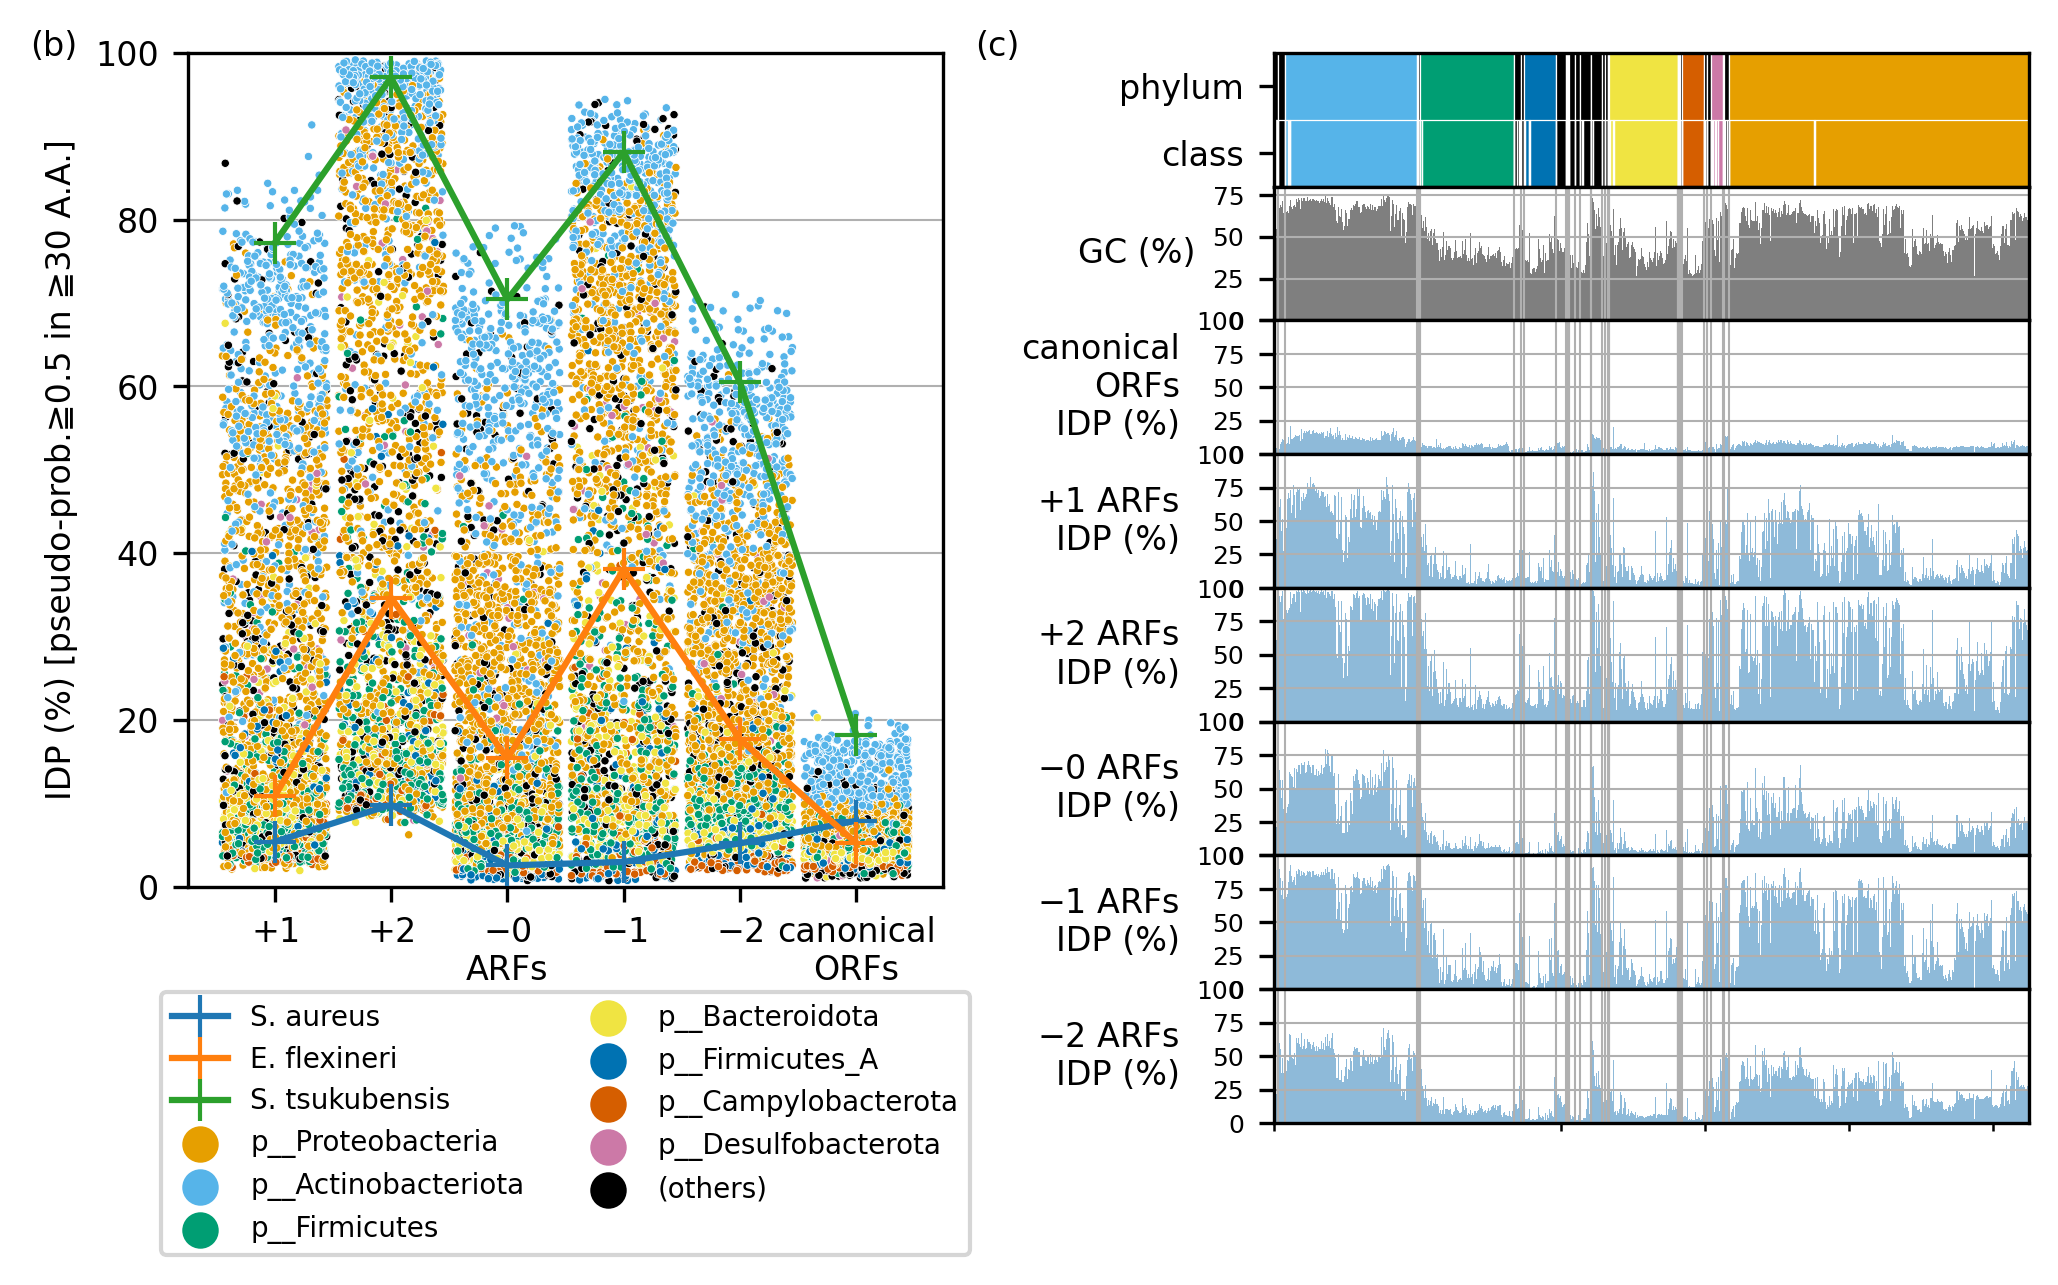

In [57]:
mm = 1 / 25.4

with plt.rc_context({'font.size': 8, 'grid.linewidth': 0.5}):
    fig = plt.figure(figsize=(174*mm, 110*mm), dpi=300)

    # Layout
    gs = GridSpec(1, 2)
    gs_left  = GridSpecFromSubplotSpec(2, 1, subplot_spec=gs[0, 0], height_ratios=[6, 1])
    gs_right = GridSpecFromSubplotSpec(8, 1, subplot_spec=gs[0, 1], hspace=0)
    ax_left = fig.add_subplot(gs_left[0])
    axes_right, ax = [], None
    for gs_left_sub in gs_right:
        axes_right.append(ax:=fig.add_subplot(gs_left_sub, sharex=ax))
        
    # Panel (b)
    ax = ax_left
    fr_mapping = {0: 'undet', 1: 'CDS', 2: '+1',  4: '+2',  8: '-0', 16: '-1', 32: '-2'}
    len_thresh, prob_thresh = 30, 0.5
    idp_ratio = idp_summary[len_thresh,prob_thresh] / idp_summary[len_thresh,0.0].fillna(0) * 100
    pltdata = idp_ratio.rename_axis(index='frame', columns='gcf').rename(index=fr_mapping).stack().rename('IDP').reset_index()
    pltdata = pltdata.assign(phylum=pltdata['gcf'].map(refseq2gtdbrep).map(phylum_masked))
    
    sns.stripplot(
        x='frame', y='IDP', data=pltdata, order=['+1', '+2', '-0', '-1', '-2', 'CDS'],
        hue='phylum', hue_order=[*top_idx, '(others)'], palette=CUD.OkabeIto_cpal,
        jitter=0.45, s=2, ec='w', linewidth=0.2, ax=ax
    )
    ax.plot(range(6), idp_ratio['GCF_000013425.1'][[2, 4, 8, 16, 32, 1]].to_list(), label='S. aureus', marker='+', ms=10, zorder=10)
    ax.plot(range(6), idp_ratio['GCF_000006925.2'][[2, 4, 8, 16, 32, 1]].to_list(), label='E. flexineri', marker='+', ms=10, zorder=10)
    ax.plot(range(6), idp_ratio['GCF_003932715.1'][[2, 4, 8, 16, 32, 1]].to_list(), label='S. tsukubensis', marker='+', ms=10, zorder=10)
    ax.legend(loc='upper center', ncol=2, bbox_to_anchor=(0.5, -0.11), fontsize='small')
    ax.set_xlabel(None)
    ax.set_ylim(0, 100),
    ax.set_ylabel(f'IDP (%) [pseudo-prob.≧{prob_thresh} in ≧{len_thresh} A.A.]')
    ax.set(
        xticks=[0, 1, 2, 3, 4, 5],
        xticklabels=['$+1$', '$+2$', '$-0$\nARFs', '$-1$', '$-2$', 'canonical\nORFs']
    )
    ax.yaxis.grid()

    # Panel (c)
    ## phylogeny
    ax = axes_right[0]
    rect = []
    for w, x, fc in zip(phylum_counts, phylum_counts.cumsum(), phylum_color):
        rect.append(plt.Rectangle((x, 0), -w, 2, lw=0.3, ec='w', fc=fc))
    for p__, grp in gtdb_taxonomy.groupby('phylum'):
        base = (phylum_counts.cumsum() - phylum_counts)[p__]
        class_cnt = grp['class'].value_counts()[grp['class'].unique()]
        rect.extend([
            plt.Rectangle((base+x, 1), -w, 1, lw=0.3, ec='w', fc='None')
            for w, x in zip(class_cnt, class_cnt.cumsum())
        ])
    ax.add_collection(PatchCollection(rect, match_original=True))
    
    ax.set(xlim=(0, len(metadata.acc)), ylim=(2, 0))
    ax.set(yticks=[0.5, 1.5], yticklabels=['phylum', 'class'])
    ax.xaxis.set_tick_params(bottom=False, labelbottom=False)
    
    ## GC
    ax = axes_right[1]
    GC[acc_ordered['refseq']].plot.bar(ax=ax, width=1, fc='k', alpha=0.5)
    ylabel_props = dict(ha='right', va='center', rotation=0)
    ax.set_ylabel('GC (%)', **ylabel_props)
    ax.set_ylim(0, 80)
        
    ## IDP ratios
    for frame, ylabel, ax in zip([1, 2, 4, 8, 16, 32], ['canonical\nORFs', '$+1$ ARFs', '$+2$ ARFs', '$-0$ ARFs', '$-1$ ARFs', '$-2$ ARFs'], axes_right[2:]):
        idp_ratio.loc[frame, acc_ordered['refseq']].plot.bar(ax=ax, width=1, fc=plt.get_cmap('tab10')(0), alpha=0.5)
        ax.set_ylabel(ylabel+'\nIDP (%)', **ylabel_props)
        ax.set_ylim(0, 100)
        
    # common settings
    for ax in axes_right[1:]:
        ax.set_xticks(phylum_counts.cumsum())
        ax.grid()
        ax.set_xlabel(None)
        ax.xaxis.set_tick_params(bottom=False, labelbottom=False)
        ax.yaxis.set_tick_params(labelsize=6)
        ax.yaxis.set_major_locator(MultipleLocator(25))
    
    fig.text(0.01, 0.98, '(b)', va='top', ha='left')
    fig.text(0.47, 0.98, '(c)', va='top', ha='left')
    fig.tight_layout()
    fig.savefig('./Figs/Fig2bc-tmp.pdf')